In [ ]:
#The analysis from this notebook has been done from this data
#132.166.26.39:/data/pipeline/CFIS_process/results/final_cat.fits

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp

### functions about healpy operations

In [94]:
def get_pixels(ra, dec, nside):
	"""
	from a set of positions ra and dec, and given a nside, it returns:
	npix: number of pixels
	pix_number: the pixel number corresponding to each position.
	true_pix: True if the pixel is not empty.
	total_pix: total number of non-empty pixels.
	"""
	npix = hp.nside2npix(nside)
	theta = dec2theta(dec)
	phi = ra2phi(ra)
	pix_number = hp.ang2pix(nside, theta, phi)
	true_pix, edges = np.histogram(pix_number, bins = np.linspace(0, npix, npix + 1))
	true_pix = true_pix >0
	total_pix = np.sum(true_pix)
	return npix, pix_number, true_pix, total_pix

def dec2theta(dec):
	theta = np.pi/2. - dec/360.*2*np.pi
	return theta

def ra2phi(ra):
	phi = ra/360.*2*np.pi
	return phi

def make_hp_map(map, pix_number, numbins_z_s, npix, params):
	"""
	It generates a healpy map from a given data. 
	Input: 
	map: an array with the mapped property.
	w: an extra weight for the data.
	z: redshift.
	pix_number: the pixel number defining the position in the healpy map.
	numbins_z_s: number of source bins.
	npix: number of healpy pixels.
	params: parameters of the calculation.
	Output:
	map_3d: the healpy map for each source redshift bin.
	"""
	map_3d, edges = np.histogram(pix_number, bins = npix, range = [-.5, npix - .5], weights=map)
	w_3d, edges = np.histogram(pix_number, bins = npix, range = [-.5, npix - .5])
	map_3d /= w_3d
	map_3d[w_3d == 0] = hp.UNSEEN
	return map_3d

### function to convert from gamma to kappa

In [4]:
def g2k(gamma1, gamma2, nside, synfast = False):
	"""
	It calculates the E and B modes of Kappa from gamma1 and 
	gamma2 shear healpy maps.
	Input:
	gamma1, gamma2: shear fields.
	nside: healpy resolution.
	synfast: if False, applies ell corrections to the conversions.
	Output:
	E_map, B_map: E and B mode corresponding maps
	"""
	L = 2*nside # should be at least 2*nside, if possible between 3 and 5 nside.
	lmax = L-1 
	KQU_gamma = [gamma1*0.0, gamma1, gamma2]
	alms = hp.map2alm(KQU_gamma, lmax=lmax, pol=True) # Spin transform
	if synfast == False:
		ell, emm = hp.Alm.getlm(lmax=lmax)
		almsE = -alms[1]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5 
		almsB = -alms[2]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
		almsE[ell==0] = 0.0
		almsB[ell==0] = 0.0
		almsE[ell==1] = 0.0
		almsB[ell==1] = 0.0
	else:
		almsE = alms[1]
		almsB = alms[2]				           
	almssm = [alms[0], almsE, almsB]
	E_map = hp.alm2map(almssm[1], nside=nside, lmax=lmax, pol=False)
	B_map = hp.alm2map(almssm[2], nside=nside, lmax=lmax, pol=False)
	return E_map, B_map



### functions for cross correlations and its errors

In [48]:
def cross_corr(grid1, grid2, jk_dim, jk_map = None, verbose = False):
    """It calculates the zero-lag correlation function of two 2d
       grids (or 1d maps) and its jack-knife error. grid1 and grid2 must have the same shape.
       If jk_map is not None, it is considered as the indexes of the JK samples of the maps."""
    if verbose:
        print "Calculating zero-lag correlation with JK error"
    #calculate grid to define JK subsamples
    if jk_map is None:
        jk_grid = make_jk_randmap(grid1, jk_dim)#Grid of indeces according to the JK they belong to
        total_jk = jk_dim**2
    else:
        jk_grid = jk_map
        total_jk = jk_dim
    #calculate zero-lag of all the grid
    corr = get_cross_corr(grid1,grid2)
    #calculate zero-lags in subgrids
    sub_corr = []
    for i in range(total_jk):
        sub_grid1 = grid1[jk_grid != i]
        sub_grid2 = grid2[jk_grid != i]
        sub_corr.append(get_cross_corr(sub_grid1, sub_grid2))
    corr_err = jack_knife(corr, sub_corr)
    return corr, corr_err

def get_cross_corr(grid1, grid2):
    """
    It calculated the cross correlation between both maps.
    """
    return np.mean(grid1*grid2)/np.sqrt(np.mean(grid1**2.)*np.mean(grid2**2.))

def jack_knife(var, jk_var):
	"""
		It gives the Jack-Knife error of var from the jk_var subsamples.
		Inputs: 
		var: the mean value of the variable. Constant number.
		jk_var: the variable from the subsamples. The shape of the jk_var must be (jk subsamples, bins)

	 	Output: 
		jk_err: the JK error of var. 
		"""
	if type(var) == np.ndarray:
		jk_dim = jk_var.shape[0]
		err = (jk_dim - 1.)/jk_dim * (jk_var - var)**2.
		jk_err = np.sqrt(np.sum(err, axis = 0))
	else:
		jk_dim = len(jk_var)
		err = (jk_dim - 1.)/jk_dim * (jk_var - var)**2.
		jk_err = np.sqrt(np.sum(err))
	return jk_err

def make_jk_randmap(grid, jk_dim):
	"""It generates a map with different indeces for each of the jk subsamples.
	   """
	grid_dim1 = grid.shape[0]
	ratio1 = grid_dim1/jk_dim + int(grid_dim1%jk_dim > 0)
	jk_grid = np.arange(grid_dim1, dtype = int)/ratio1
	return jk_grid

### Parameters to be defined 

In [77]:
params = {
'nside' : 2048, #healpy resolution
'smooth' : 10., #smoothing scale to apply (if asked) to the maps
'jk' : 20, #number of Jack-Knife realizations
}

# Read data 

In [7]:
a = fits.open('/Users/apujol/Documents/physics/codes/test/CFIS/final_cat.fits', ignore_missing_end=True)
data = a[1].data
print a[1].columns
a.close()

ColDefs(
    name = 'g1_median'; format = '1D'
    name = 'm1_2'; format = '1D'
    name = 'm1_1'; format = '1D'
    name = 'g2_median_cfhtlens'; format = '1D'
    name = 'e2_diff_median_abs'; format = '1D'
    name = 'mag'; format = '1D'
    name = 'p1_1'; format = '1D'
    name = 'g1_object'; format = '1D'
    name = 'n_field'; format = '1D'
    name = 'p1_2'; format = '1D'
    name = 'flux_radius'; format = '1D'
    name = 'g2_mean_field'; format = '1D'
    name = 'g1_mean'; format = '1D'
    name = 'g1_mean_field'; format = '1D'
    name = 'p2_2'; format = '1D'
    name = 'p2_1'; format = '1D'
    name = 'e2_diff_median'; format = '1D'
    name = 'R11'; format = '1D'
    name = 'ns_1'; format = '1D'
    name = 'ns_2'; format = '1D'
    name = 'n_star'; format = '1D'
    name = 'm2_1'; format = '1D'
    name = 'm2_2'; format = '1D'
    name = 'e2_diff_mean'; format = '1D'
    name = 'ra'; format = '1D'
    name = 'dist_cfis_cfhtlens'; format = '1D'
    name = 'g1_median_cfhtlens'; f

    Header size is not multiple of 2880: 109758960
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


These are all the CFIS ellipticity estimations from the data: 
- gi_median is the calibrated ellipticity from the median responses r11 and r22
- gi_mean is the same but from the mean responses. 
- ns_i is the original ellipticity_i
- gi_mean_field is the calibrated ellipticity from the mean responses of each field
- gi_median_field is the calibrated ellipticity from the median responses of each field
- gi_object is the calibrated data from their individual responses

### Some histograms 

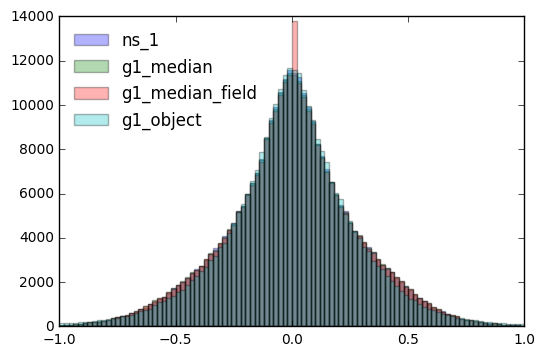

In [10]:
plt.hist(data['ns_1'],100, range = [-1,1], alpha = .3, label = 'ns_1')
plt.hist(data['g1_median'],100, range = [-1,1], alpha = .3, label = 'g1_median')
plt.hist(data['g1_median_field'],100, range = [-1,1], alpha = .3, label = 'g1_median_field')
plt.hist(data['g1_object'],100, range = [-1,1], alpha = .3, label = 'g1_object')
plt.legend(frameon = False, loc = 2)
plt.show()



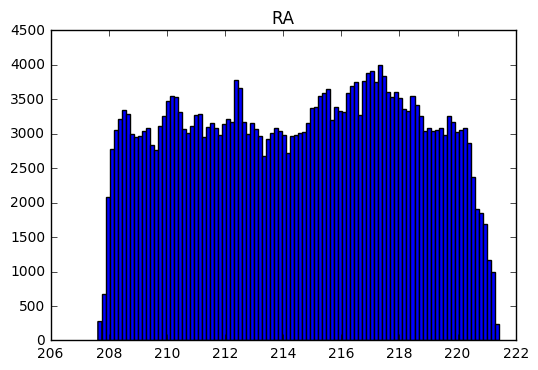

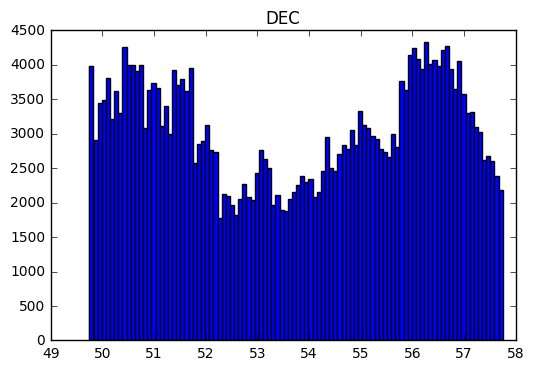

In [11]:
plt.hist(data['ra'],100)
plt.title('RA')
plt.show()
plt.hist(data['dec'],100)
plt.title('DEC')
plt.show()

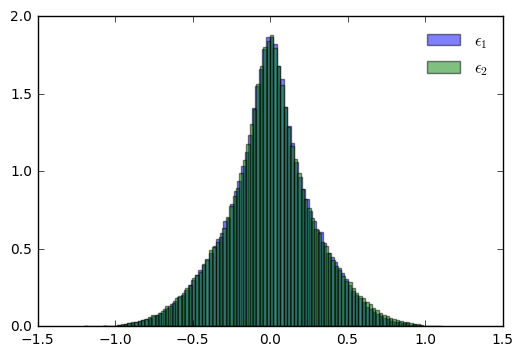

In [76]:
plt.hist(data['g1_mean'], 100, normed=True, alpha = .5, label = r'$\epsilon_1$')
plt.hist(data['g2_mean'], 100, normed=True, alpha = .5, label = r'$\epsilon_2$')
plt.legend(frameon = False)
plt.show()

#  make and plot number counts

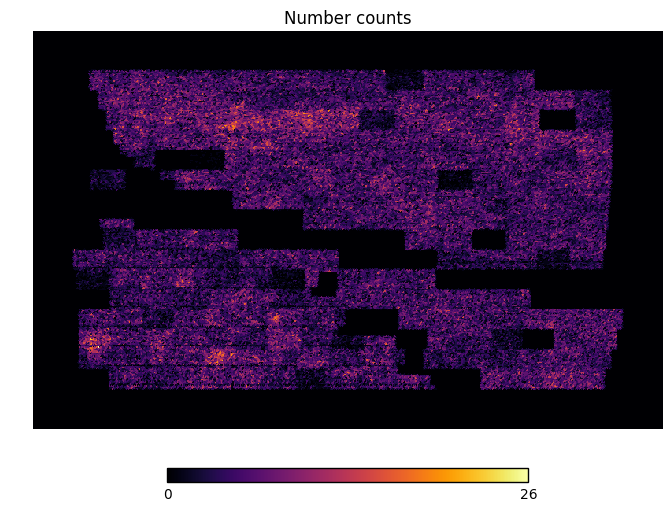

In [14]:
npix, pix_number, true_pix, total_pix = get_pixels(data['ra'], data['dec'], params['nside'])
num_counts, edge_bins = np.histogram(pix_number, bins = npix, range = [-.5, npix - .5])
hp.cartview(num_counts, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno')
plt.title('Number counts')

The following histogram shows the distances between CFIS and CFHT galaxies. We can see that many galaxies have a very small distance, meaning they are the same galaxies. Then, we have an intermediate scale where we don't find galaxies with this separation. This can be an exclusion effect due to impossibility of finding different galaxies that close. Then we have again galaxies with larger distances, meaning they are different object. From this plot, I will define the galaxies matched with CHFT as the ones in the first bin

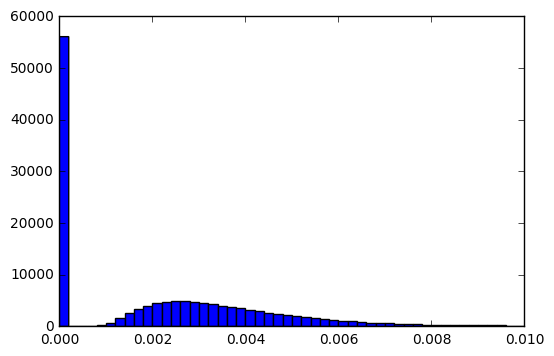

In [18]:
plt.hist(data['dist_cfis_cfhtlens'],50, range=[0,.01])
plt.show()

In [78]:
cfht_matched = data['dist_cfis_cfhtlens']<.001

number of galaxies vs number of galaxies matched with CFHT is: 

In [20]:
len(pix_number), np.sum(cfht_matched)

(304886, 56374)

### Number counts of galaxies matched with CFHT 

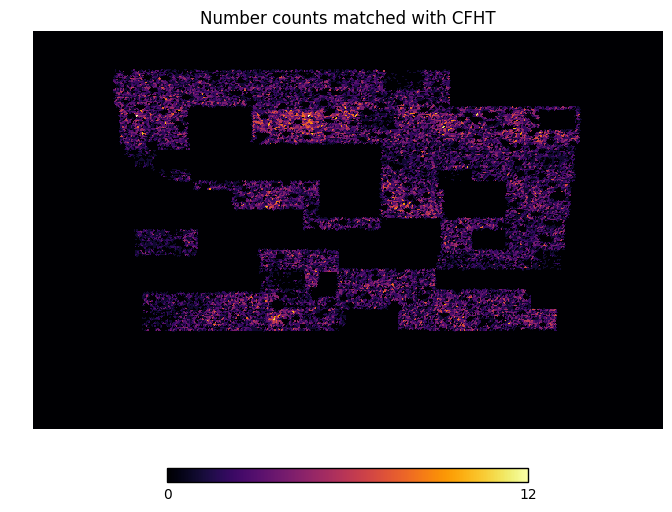

In [21]:
num_counts_cfht, edge_bins = np.histogram(pix_number[cfht_matched], bins = npix, range = [-.5, npix - .5])
hp.cartview(num_counts_cfht, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno')
plt.title('Number counts matched with CFHT')

### Overlapp between matched and unmatched galaxies 

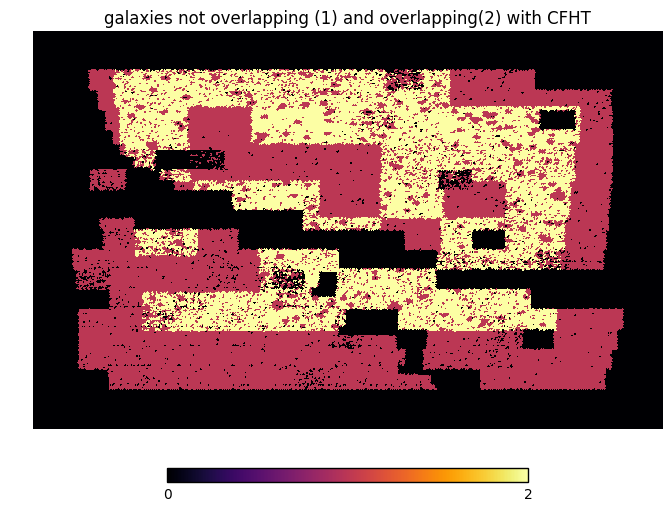

In [22]:
overlap = np.array((num_counts> 0), dtype=int) + np.array(num_counts_cfht>0, dtype=int)
hp.cartview(overlap, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno')
plt.title('galaxies not overlapping (1) and overlapping(2) with CFHT')

### make and show mask 

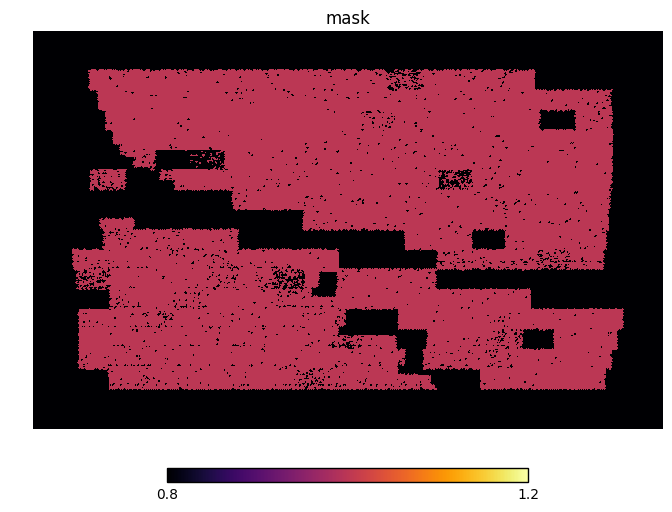

In [79]:
mask = num_counts > 0
hp.cartview(mask, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno', min = .8, max = 1.2)
plt.title('mask')
plt.show()

# make and plot shear and kappa maps 

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in divide


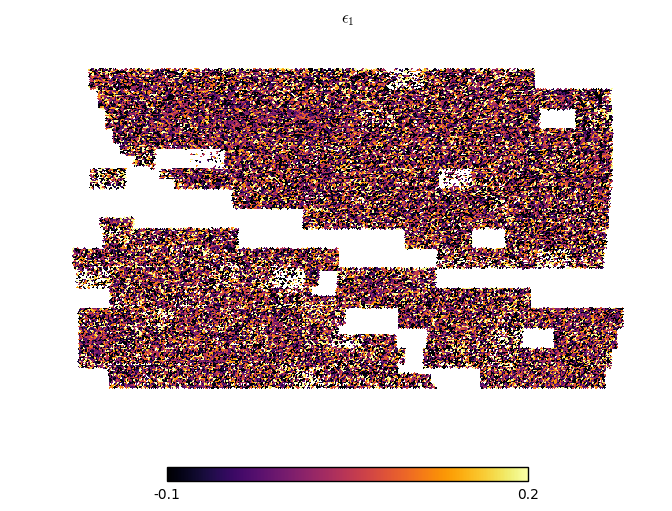

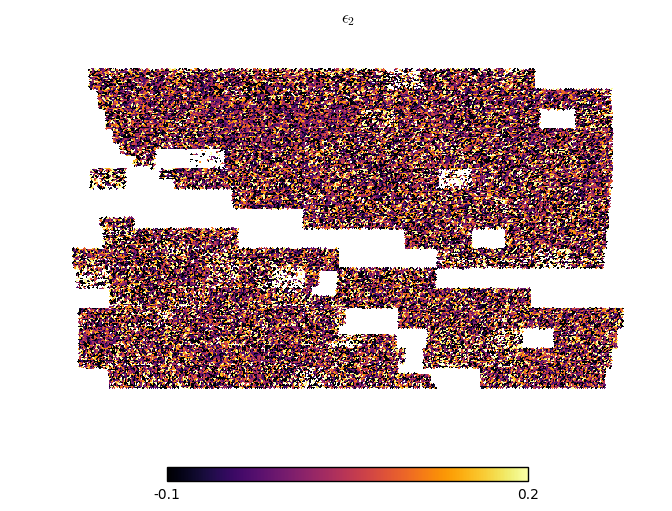

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in multiply
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in divide
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in multiply


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


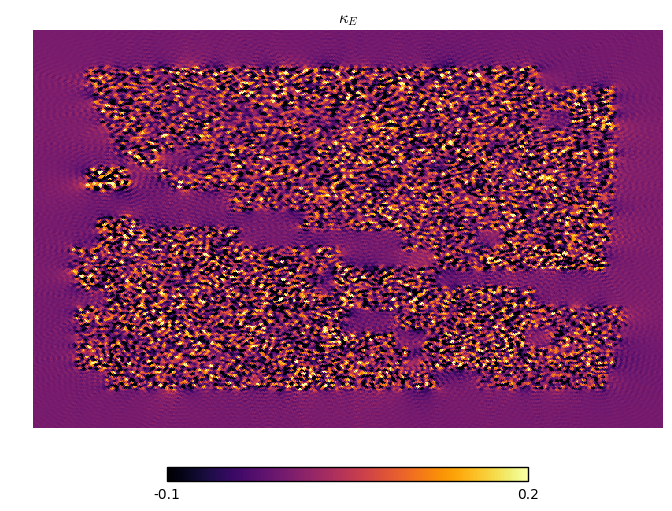

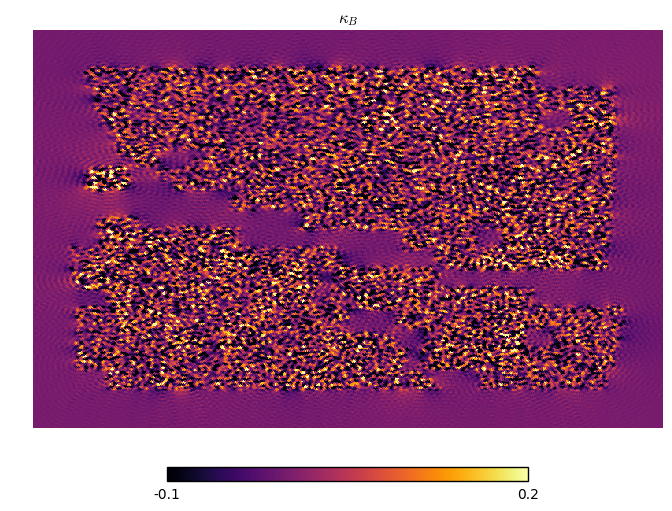

In [97]:
ellip1 = make_hp_map(data['g1_median'], pix_number, 1, npix, params)
ellip2 = make_hp_map(data['g2_median'], pix_number, 1, npix, params)
hp.cartview(ellip1, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno', min = -.1, max = .2)
plt.title(r'$\epsilon_1$')
plt.show()
hp.cartview(ellip2, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno', min = -.1, max = .2)
plt.title(r'$\epsilon_2$')
plt.show()

kappa_E, kappa_B = g2k(ellip1, ellip2, params['nside'])
hp.cartview(kappa_E, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno', min = -.1, max = .2)
plt.title(r'$\kappa_E$')
plt.show()
hp.cartview(kappa_B, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno', min = -.1, max = .2)
plt.title(r'$\kappa_B$')
plt.show()

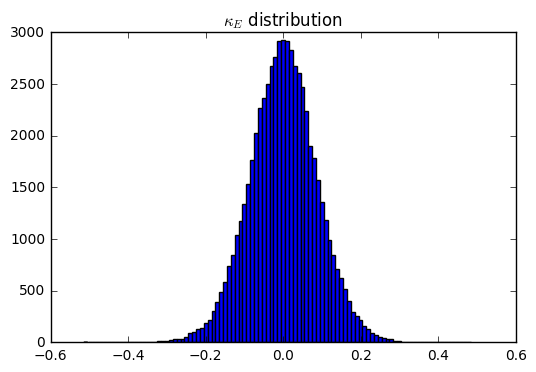

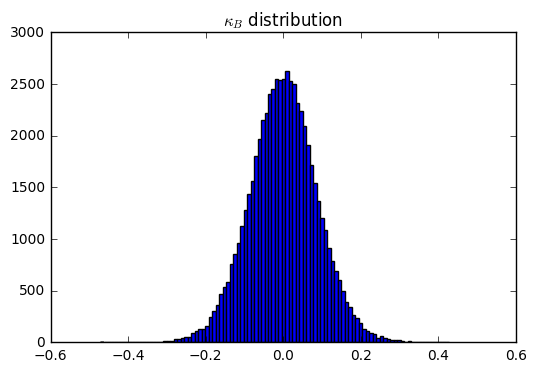

In [92]:
plt.hist(kappa_E[mask],100)
plt.title(r'$\kappa_E$ distribution')
plt.show()
plt.hist(kappa_B[mask],100)
plt.title(r'$\kappa_B$ distribution')
plt.show()

# Other maps 

In [27]:
stars_in_field = np.array([data['n_star'][i] for i in data['n_field']])
    

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in divide


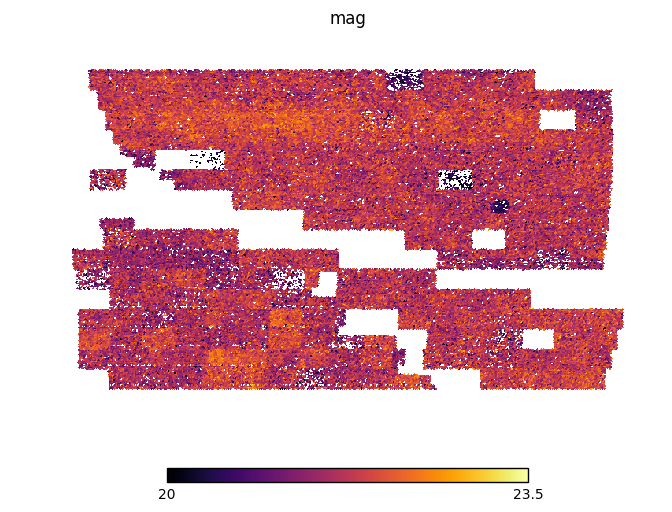

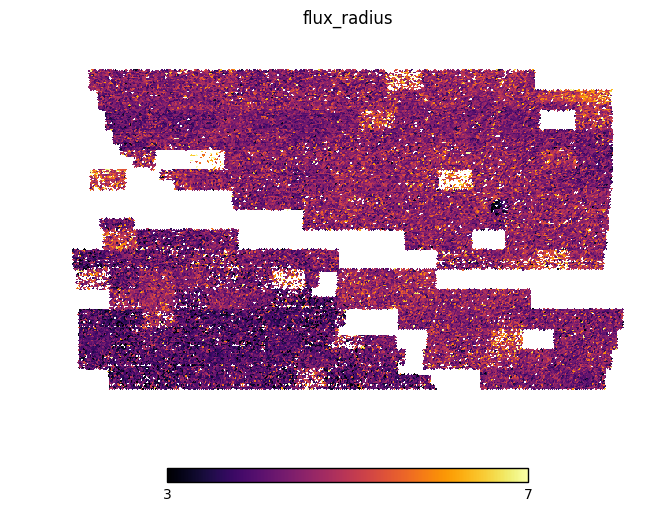

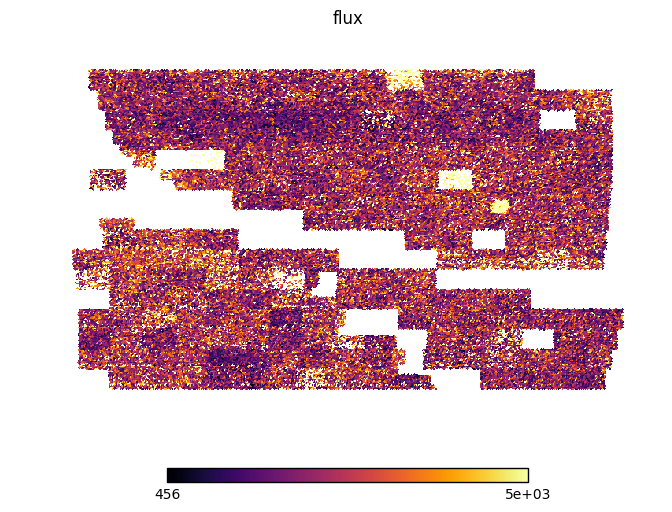

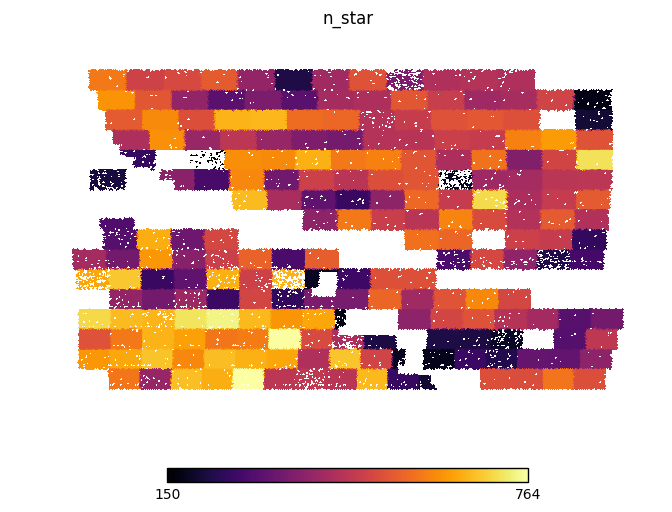

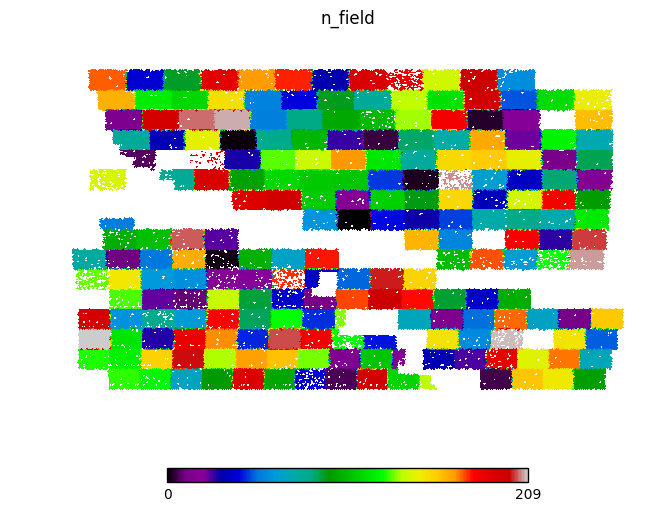

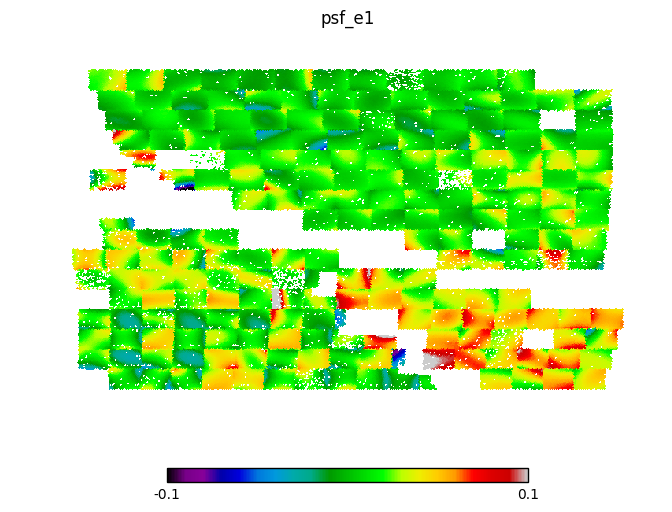

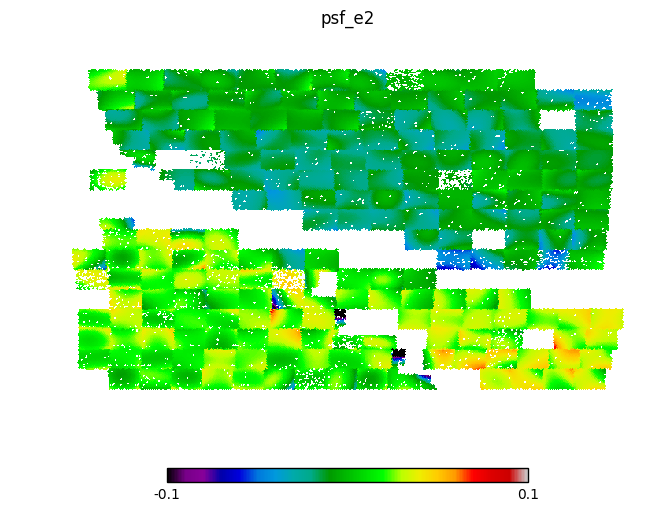

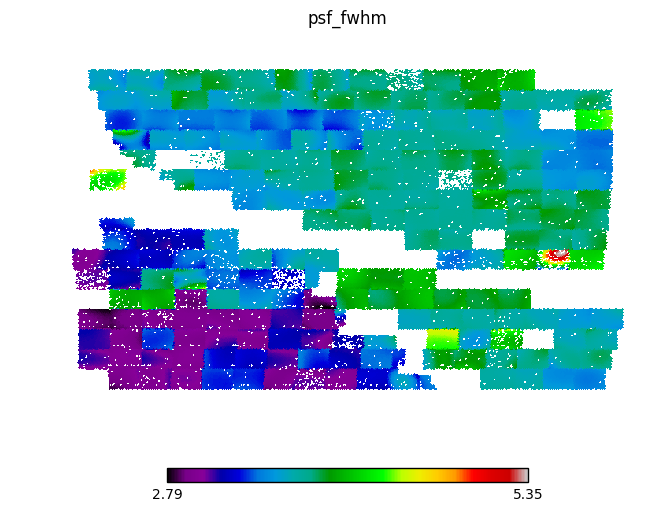

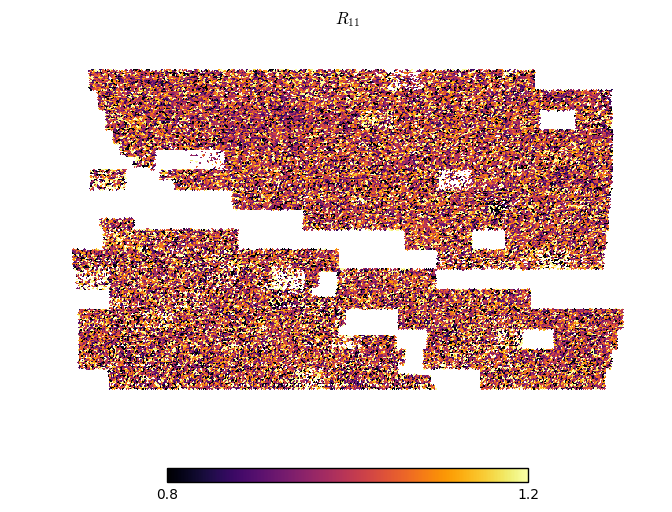

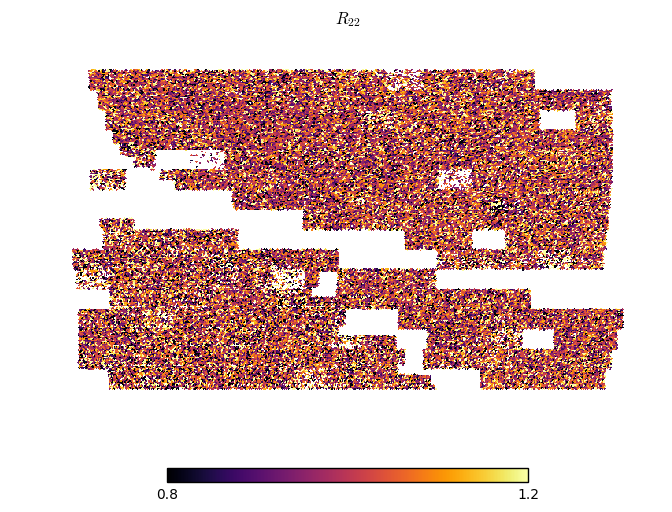

In [98]:
filt = data['mag'] < 30
mag = make_hp_map(data['mag'][filt], pix_number[filt], 1, npix, params)
hp.cartview(mag, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno')
plt.title(r'mag')
plt.show()

filt = data['flux_radius'] > 0
flux_radius = make_hp_map(data['flux_radius'][filt], pix_number[filt], 1, npix, params)
hp.cartview(flux_radius, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno', min = 3, max = 7)
plt.title(r'flux_radius')
plt.show()

filt = data['flux'] > 0
flux = make_hp_map(data['flux'][filt], pix_number[filt], 1, npix, params)
hp.cartview(flux, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno', max = 5000)
plt.title(r'flux')
plt.show()

n_star = make_hp_map(stars_in_field, pix_number, 1, npix, params)
hp.cartview(n_star, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno')
plt.title(r'n_star')
plt.show()


n_field = make_hp_map(data['n_field'], pix_number, 1, npix, params)
hp.cartview(n_field, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'nipy_spectral')
plt.title(r'n_field')
plt.show()

psf_e1 = make_hp_map(data['PSF_e1'], pix_number, 1, npix, params)
hp.cartview(psf_e1, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'nipy_spectral', min = -.1, max = .1)
plt.title(r'psf_e1')
plt.show()

psf_e2 = make_hp_map(data['PSF_e2'], pix_number, 1, npix, params)
hp.cartview(psf_e2, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'nipy_spectral', min = -.1, max = .1)
plt.title(r'psf_e2')
plt.show()

psf_fwhm = make_hp_map(data['PSF_fwhm'], pix_number, 1, npix, params)
hp.cartview(psf_fwhm, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'nipy_spectral')
plt.title(r'psf_fwhm')
plt.show()

r11_map = make_hp_map(data['r11'], pix_number, 1, npix, params)
hp.cartview(r11_map, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno', min = .8, max = 1.2)
plt.title(r'$R_{11}$')
plt.show()

r22_map = make_hp_map(data['r22'], pix_number, 1, npix, params)
hp.cartview(r22_map, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno', min = .8, max = 1.2)
plt.title(r'$R_{22}$')
plt.show()

# Dependencies on ellipticity and responses 

Here I show the average ellipticities (y-axis) as a function of other properties (x-axis). Each point shows the average of both properties for each field. The solid lines show the linear fit of the distribution.   

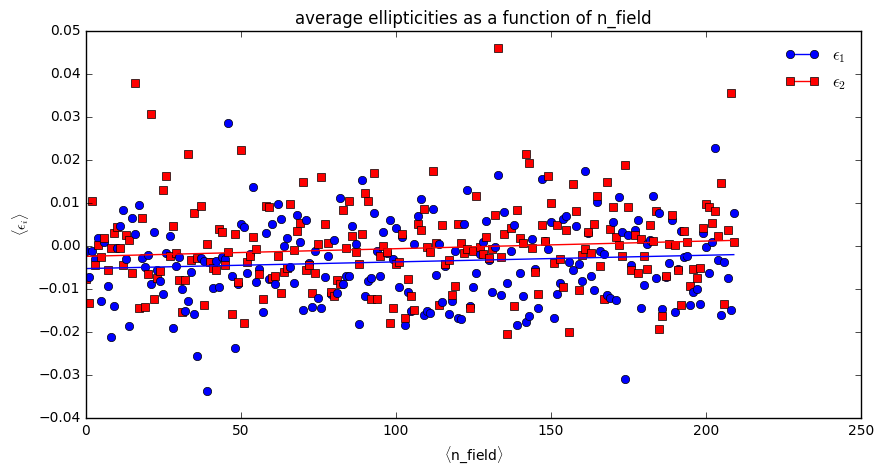

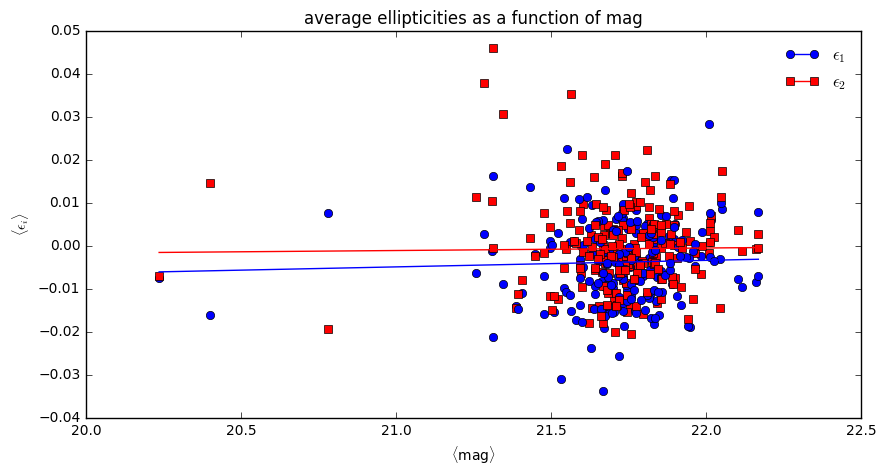

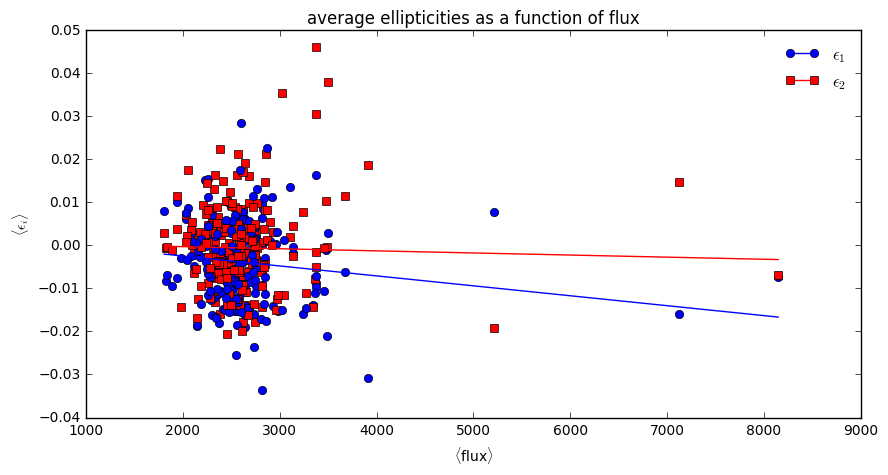

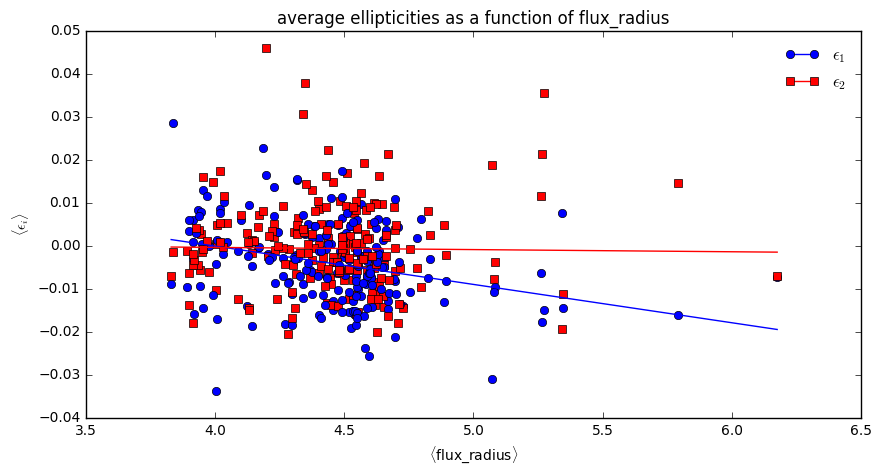

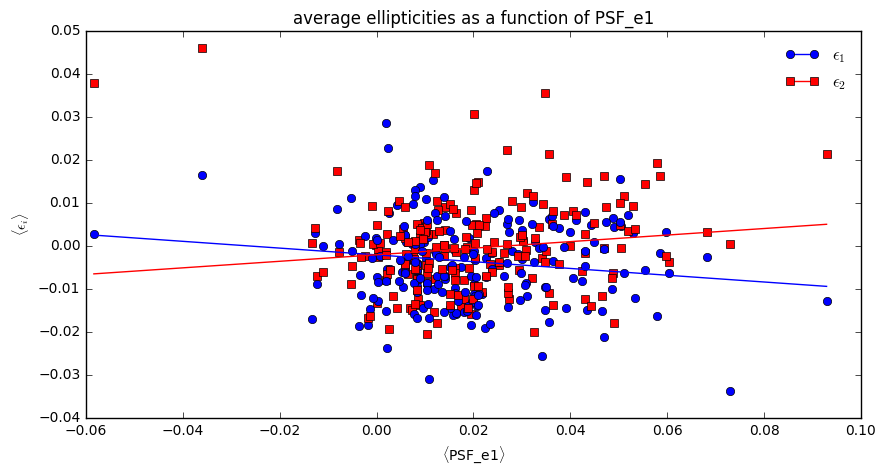

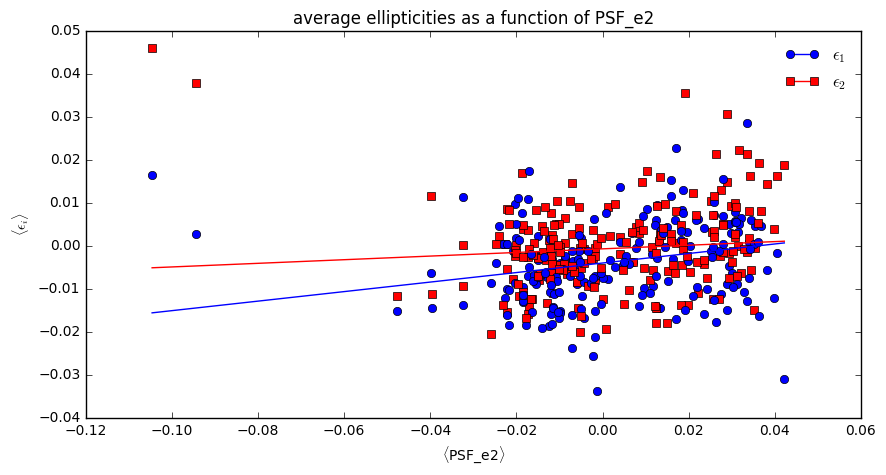

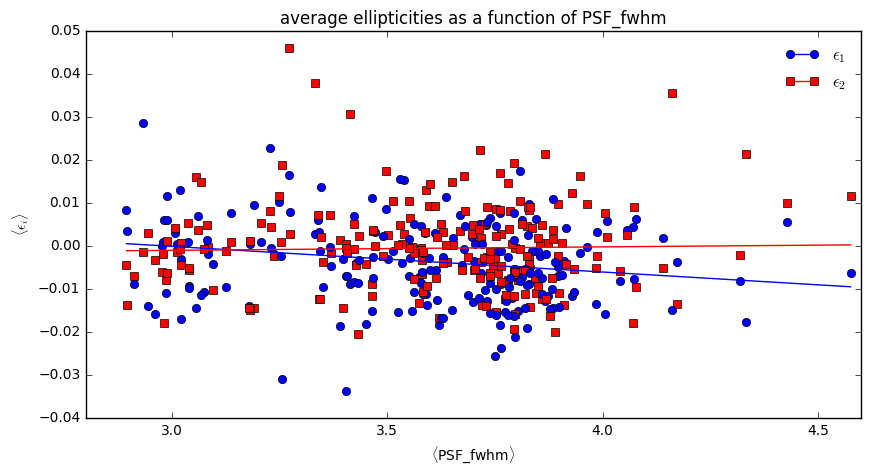

In [31]:
for name in ['n_field', 'mag', 'flux', 'flux_radius', 'PSF_e1', 'PSF_e2', 'PSF_fwhm']:
    plt.figure(figsize=[10,5])
    for i in np.unique(data['n_field']):
        plt.plot(np.mean(data[name][data['n_field'] == i]), np.mean(data['g1_median'][data['n_field'] == i]), marker = 'o', c = 'b', label = r'$\epsilon_{1}$')
        plt.plot(np.mean(data[name][data['n_field'] == i]), np.mean(data['g2_median'][data['n_field'] == i]), marker = 's', c = 'r', label = r'$\epsilon_{2}$')
    xvals = [np.mean(data[name][data['n_field'] == i]) for i in np.unique(data['n_field'])]
    b, a = np.polyfit(data[name], data['g1_median'], 1)
    plt.plot([min(xvals), max(xvals)], [a + b*min(xvals), a + b*max(xvals)], c = 'b')
    b, a = np.polyfit(data[name], data['g2_median'], 1)
    plt.plot([min(xvals), max(xvals)], [a + b*min(xvals), a + b*max(xvals)], c = 'r')
    plt.title('average ellipticities as a function of ' + name)
    plt.ylabel(r'$\langle \epsilon_i \rangle$')
    plt.xlabel(r'$\langle $'+name+'$ \\rangle$')
    plt.legend([r'$\epsilon_{1}$', r'$\epsilon_{2}$'], loc = 1, frameon = False)
    plt.show()

Here I show the same as before, but using the average Metacalibration responses in the y axis instead of the ellipticities.  

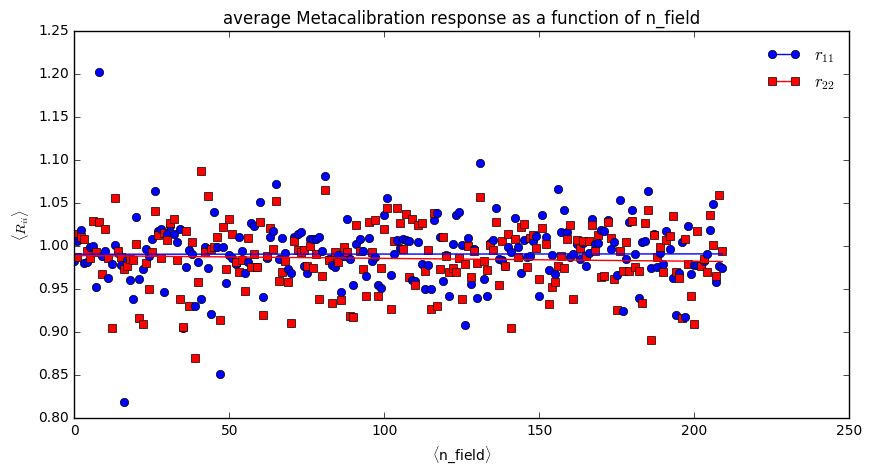

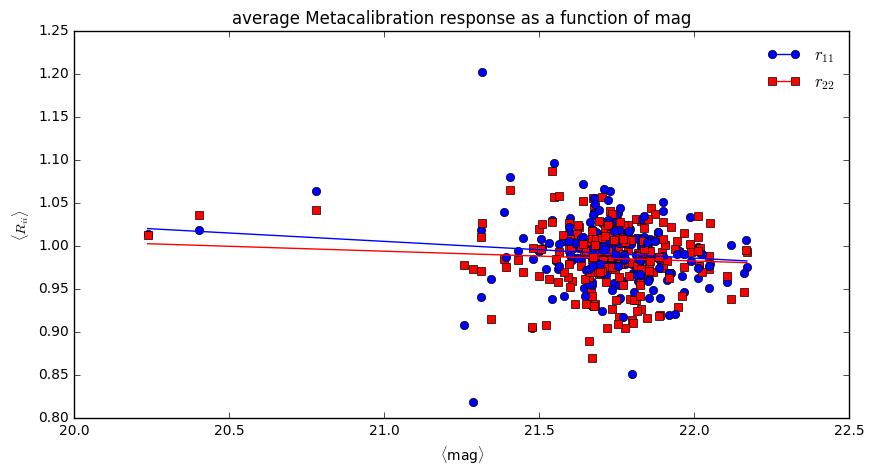

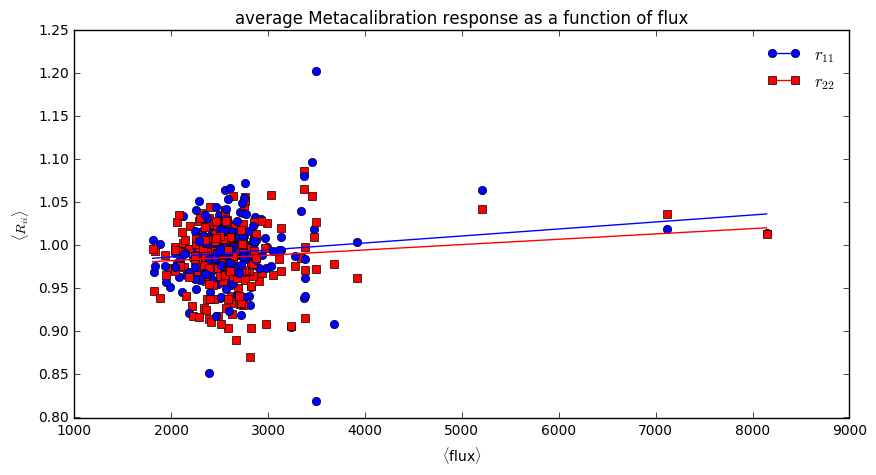

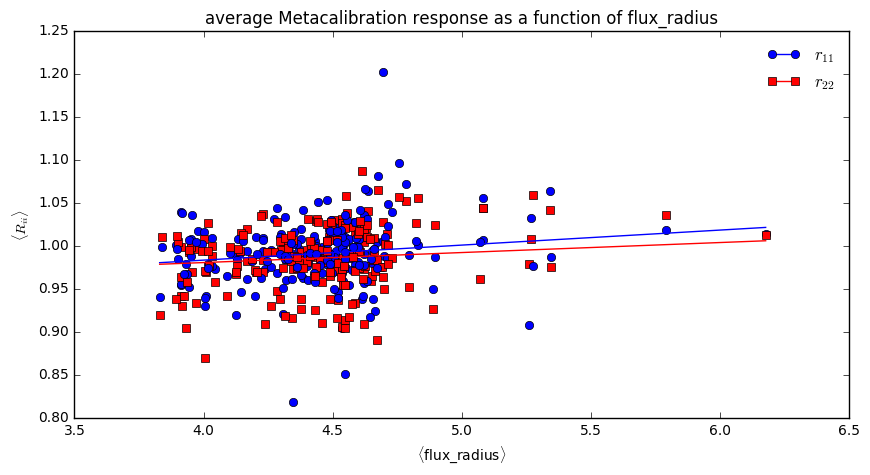

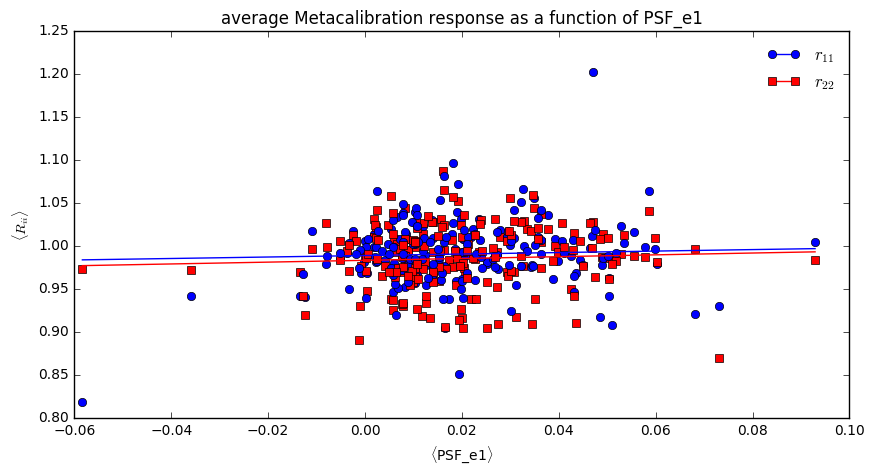

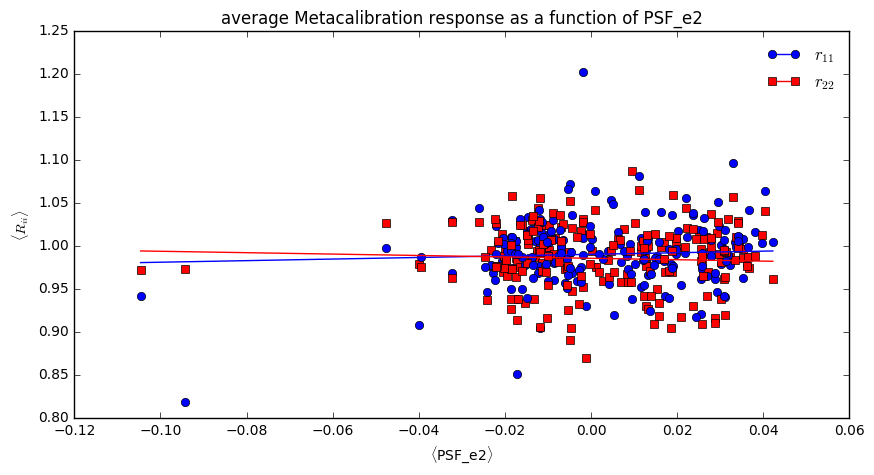

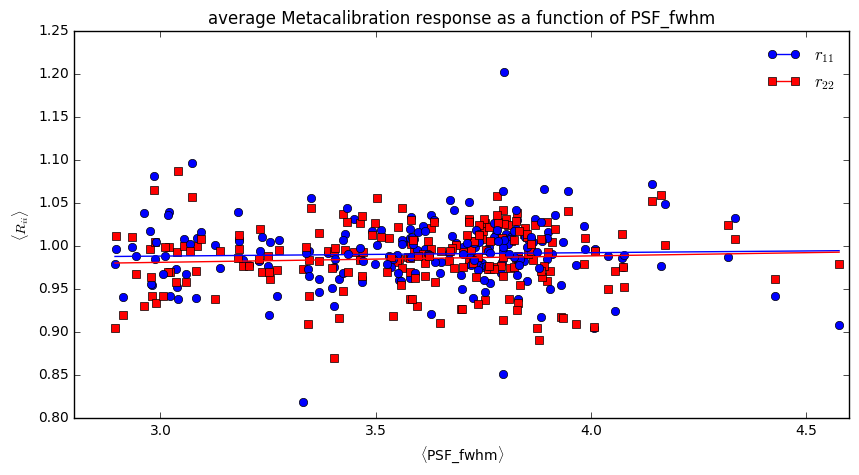

In [32]:
for name in ['n_field', 'mag', 'flux', 'flux_radius', 'PSF_e1', 'PSF_e2', 'PSF_fwhm']:
    plt.figure(figsize=[10,5])
    for i in np.unique(data['n_field']):
        plt.plot(np.mean(data[name][data['n_field'] == i]), np.mean(data['r11'][data['n_field'] == i]), marker = 'o', c = 'b', label = r'$r_{11}$')
        plt.plot(np.mean(data[name][data['n_field'] == i]), np.mean(data['r22'][data['n_field'] == i]), marker = 's', c = 'r', label = r'$r_{22}$')
    xvals = [np.mean(data[name][data['n_field'] == i]) for i in np.unique(data['n_field'])]
    b, a = np.polyfit(data[name], data['r11'], 1)
    plt.plot([min(xvals), max(xvals)], [a + b*min(xvals), a + b*max(xvals)], c = 'b')
    b, a = np.polyfit(data[name], data['r22'], 1)
    plt.plot([min(xvals), max(xvals)], [a + b*min(xvals), a + b*max(xvals)], c = 'r')
    plt.title('average Metacalibration response as a function of ' + name)
    plt.ylabel(r'$\langle R_{ii} \rangle$')
    plt.xlabel(r'$\langle $'+name+'$ \\rangle$')
    plt.legend([r'$r_{11}$', r'$r_{22}$'], loc = 1, frameon = False)
    plt.show()

# Cross correlations
Here I plot $\langle ab\rangle/\sqrt{\langle a^2\rangle\langle b^2\rangle}$, where $a$ is one map (specified in the title of the plots) and $b$ is another map (specified in the x-axis). This gives values between -1 (negative for anticorrelated maps) and 1 (positive for correlated maps). I calculate the correlations between all the maps, each plot focuses on one map and all its correlations. The values of these correlations are printed before the plot.

Cross-corr(num_counts,num_counts) = 0.123097473119 +/- 0.152005277202
Cross-corr(num_counts,ellip1) = -0.0201412504673 +/- 0.00533825268115
Cross-corr(num_counts,ellip2) = -0.00304740680514 +/- 0.00377224959902
Cross-corr(num_counts,kappa_E) = -0.00334824004967 +/- 0.00641463624753
Cross-corr(num_counts,kappa_B) = -0.00361812235986 +/- 0.00536177415267
Cross-corr(num_counts,r11_map) = 0.74231058774 +/- 0.0182810587769
Cross-corr(num_counts,r22_map) = 0.746702126114 +/- 0.0135621762065
Cross-corr(num_counts,psf_e1) = 0.576510352026 +/- 0.0319665807129
Cross-corr(num_counts,psf_e2) = 0.118732555897 +/- 0.140697234417
Cross-corr(num_counts,psf_fwhm) = 0.866645152644 +/- 0.00382051569436


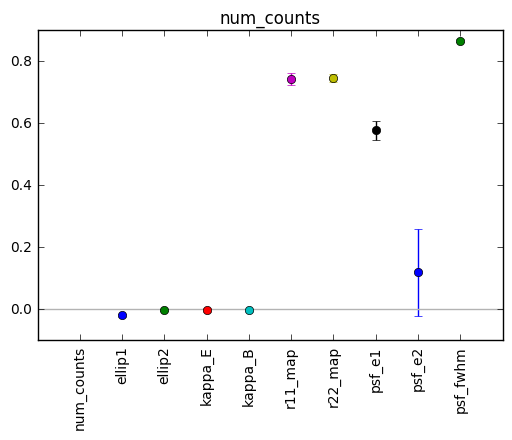

Cross-corr(ellip1,num_counts) = -0.0201412504673 +/- 0.00533825268115
Cross-corr(ellip1,ellip1) = -0.0201412504673 +/- 0.00533825268115
Cross-corr(ellip1,ellip2) = 0.011451510386 +/- 0.006058526732
Cross-corr(ellip1,kappa_E) = 0.0113715044028 +/- 0.00489116588095
Cross-corr(ellip1,kappa_B) = 0.00391232560685 +/- 0.00473333264641
Cross-corr(ellip1,r11_map) = -0.018464348108 +/- 0.00916586045981
Cross-corr(ellip1,r22_map) = -0.0166104753286 +/- 0.00655978134526
Cross-corr(ellip1,psf_e1) = -0.0250419140009 +/- 0.00577337409353
Cross-corr(ellip1,psf_e2) = 0.0105747530153 +/- 0.00433518378546
Cross-corr(ellip1,psf_fwhm) = -0.0216515913911 +/- 0.00644495645609


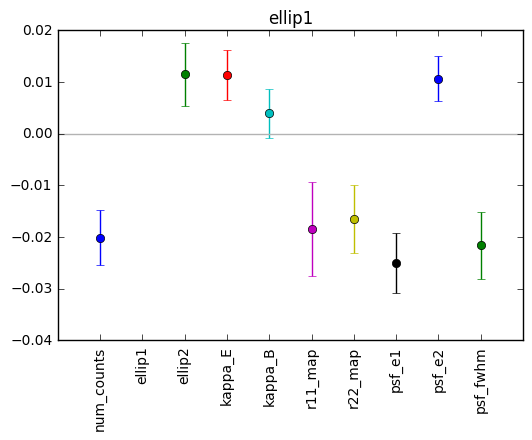

Cross-corr(ellip2,num_counts) = -0.00304740680514 +/- 0.00377224959902
Cross-corr(ellip2,ellip1) = 0.011451510386 +/- 0.006058526732
Cross-corr(ellip2,ellip2) = 0.011451510386 +/- 0.006058526732
Cross-corr(ellip2,kappa_E) = -0.000269808275926 +/- 0.00654642835948
Cross-corr(ellip2,kappa_B) = -0.000525216692307 +/- 0.0051833406769
Cross-corr(ellip2,r11_map) = 0.000364813980808 +/- 0.00606172731766
Cross-corr(ellip2,r22_map) = -0.00346577244727 +/- 0.007018462346
Cross-corr(ellip2,psf_e1) = 0.00852717750262 +/- 0.00568016984574
Cross-corr(ellip2,psf_e2) = 0.00550822011014 +/- 0.005151250219
Cross-corr(ellip2,psf_fwhm) = 0.00110404009314 +/- 0.00529025041956


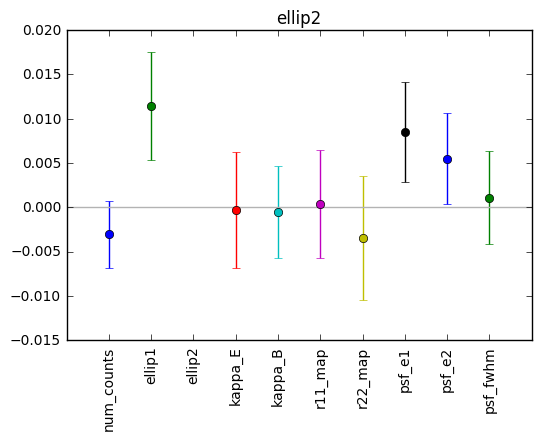

Cross-corr(kappa_E,num_counts) = -0.00334824004967 +/- 0.00641463624753
Cross-corr(kappa_E,ellip1) = 0.0113715044028 +/- 0.00489116588095
Cross-corr(kappa_E,ellip2) = -0.000269808275926 +/- 0.00654642835948
Cross-corr(kappa_E,kappa_E) = -0.000269808275926 +/- 0.00654642835948
Cross-corr(kappa_E,kappa_B) = -0.00222053178289 +/- 0.00700166141305
Cross-corr(kappa_E,r11_map) = -0.00167878347848 +/- 0.00627656769278
Cross-corr(kappa_E,r22_map) = -0.00424645174184 +/- 0.00627274494867
Cross-corr(kappa_E,psf_e1) = -0.00993040393303 +/- 0.00592395905342
Cross-corr(kappa_E,psf_e2) = -0.00979450359036 +/- 0.00651131862971
Cross-corr(kappa_E,psf_fwhm) = 0.000667960210626 +/- 0.0077286978032


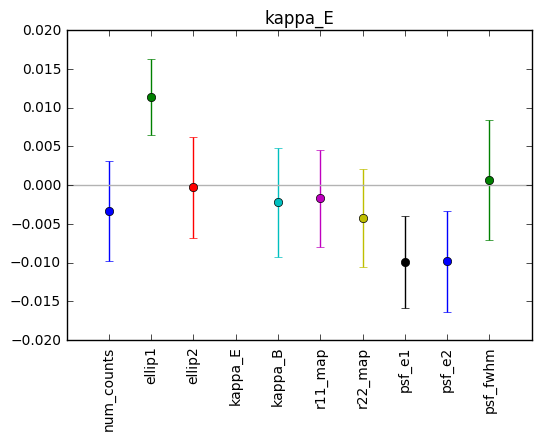

Cross-corr(kappa_B,num_counts) = -0.00361812235986 +/- 0.00536177415267
Cross-corr(kappa_B,ellip1) = 0.00391232560685 +/- 0.00473333264641
Cross-corr(kappa_B,ellip2) = -0.000525216692307 +/- 0.0051833406769
Cross-corr(kappa_B,kappa_E) = -0.00222053178289 +/- 0.00700166141305
Cross-corr(kappa_B,kappa_B) = -0.00222053178289 +/- 0.00700166141305
Cross-corr(kappa_B,r11_map) = -0.00312402574781 +/- 0.00533913044065
Cross-corr(kappa_B,r22_map) = -0.000196274043029 +/- 0.00600248975732
Cross-corr(kappa_B,psf_e1) = -0.00320704432947 +/- 0.00756839760404
Cross-corr(kappa_B,psf_e2) = -0.0163297535112 +/- 0.00872215764693
Cross-corr(kappa_B,psf_fwhm) = -0.000162150748814 +/- 0.0057284957952


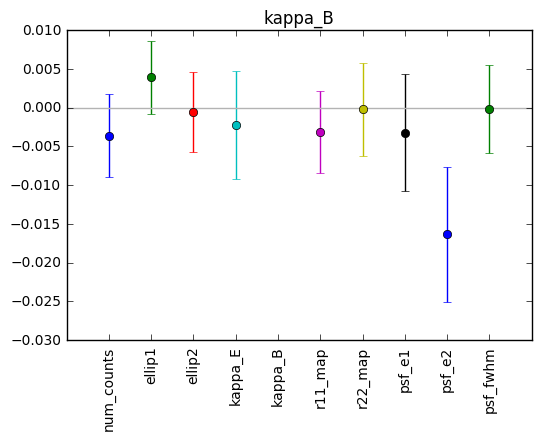

Cross-corr(r11_map,num_counts) = 0.74231058774 +/- 0.0182810587769
Cross-corr(r11_map,ellip1) = -0.018464348108 +/- 0.00916586045981
Cross-corr(r11_map,ellip2) = 0.000364813980808 +/- 0.00606172731766
Cross-corr(r11_map,kappa_E) = -0.00167878347848 +/- 0.00627656769278
Cross-corr(r11_map,kappa_B) = -0.00312402574781 +/- 0.00533913044065
Cross-corr(r11_map,r11_map) = -0.00312402574781 +/- 0.00533913044065
Cross-corr(r11_map,r22_map) = 0.766867207196 +/- 0.0418417026957
Cross-corr(r11_map,psf_e1) = 0.569281321664 +/- 0.0260978979037
Cross-corr(r11_map,psf_e2) = 0.125016535787 +/- 0.128234768581
Cross-corr(r11_map,psf_fwhm) = 0.848030767136 +/- 0.020636662928


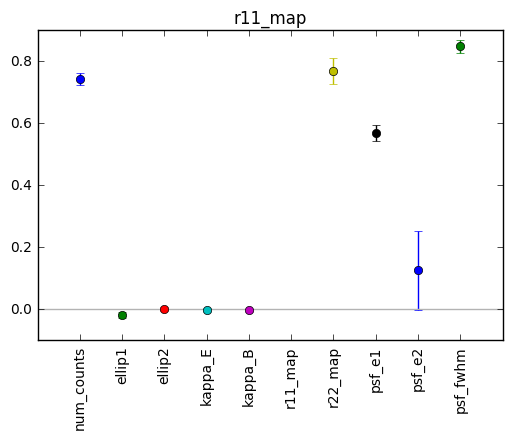

Cross-corr(r22_map,num_counts) = 0.746702126114 +/- 0.0135621762065
Cross-corr(r22_map,ellip1) = -0.0166104753286 +/- 0.00655978134526
Cross-corr(r22_map,ellip2) = -0.00346577244727 +/- 0.007018462346
Cross-corr(r22_map,kappa_E) = -0.00424645174184 +/- 0.00627274494867
Cross-corr(r22_map,kappa_B) = -0.000196274043029 +/- 0.00600248975732
Cross-corr(r22_map,r11_map) = 0.766867207196 +/- 0.0418417026957
Cross-corr(r22_map,r22_map) = 0.766867207196 +/- 0.0418417026957
Cross-corr(r22_map,psf_e1) = 0.571216747525 +/- 0.0247128926285
Cross-corr(r22_map,psf_e2) = 0.126932836045 +/- 0.130203062637
Cross-corr(r22_map,psf_fwhm) = 0.853438927592 +/- 0.0162107983734


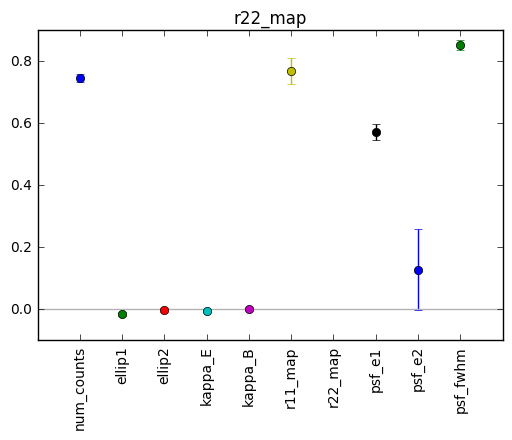

Cross-corr(psf_e1,num_counts) = 0.576510352026 +/- 0.0319665807129
Cross-corr(psf_e1,ellip1) = -0.0250419140009 +/- 0.00577337409353
Cross-corr(psf_e1,ellip2) = 0.00852717750262 +/- 0.00568016984574
Cross-corr(psf_e1,kappa_E) = -0.00993040393303 +/- 0.00592395905342
Cross-corr(psf_e1,kappa_B) = -0.00320704432947 +/- 0.00756839760404
Cross-corr(psf_e1,r11_map) = 0.569281321664 +/- 0.0260978979037
Cross-corr(psf_e1,r22_map) = 0.571216747525 +/- 0.0247128926285
Cross-corr(psf_e1,psf_e1) = 0.571216747525 +/- 0.0247128926285
Cross-corr(psf_e1,psf_e2) = 0.342554037321 +/- 0.114039810743
Cross-corr(psf_e1,psf_fwhm) = 0.674994474262 +/- 0.0322505765247


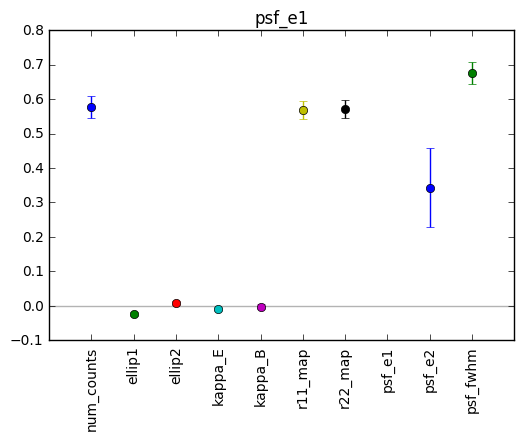

Cross-corr(psf_e2,num_counts) = 0.118732555897 +/- 0.140697234417
Cross-corr(psf_e2,ellip1) = 0.0105747530153 +/- 0.00433518378546
Cross-corr(psf_e2,ellip2) = 0.00550822011014 +/- 0.005151250219
Cross-corr(psf_e2,kappa_E) = -0.00979450359036 +/- 0.00651131862971
Cross-corr(psf_e2,kappa_B) = -0.0163297535112 +/- 0.00872215764693
Cross-corr(psf_e2,r11_map) = 0.125016535787 +/- 0.128234768581
Cross-corr(psf_e2,r22_map) = 0.126932836045 +/- 0.130203062637
Cross-corr(psf_e2,psf_e1) = 0.342554037321 +/- 0.114039810743
Cross-corr(psf_e2,psf_e2) = 0.342554037321 +/- 0.114039810743
Cross-corr(psf_e2,psf_fwhm) = 0.123097473119 +/- 0.152005277202


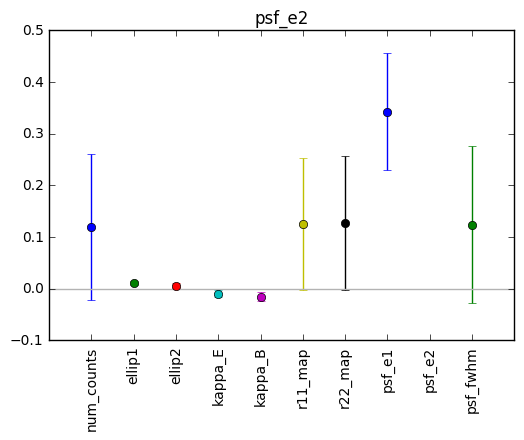

Cross-corr(psf_fwhm,num_counts) = 0.866645152644 +/- 0.00382051569436
Cross-corr(psf_fwhm,ellip1) = -0.0216515913911 +/- 0.00644495645609
Cross-corr(psf_fwhm,ellip2) = 0.00110404009314 +/- 0.00529025041956
Cross-corr(psf_fwhm,kappa_E) = 0.000667960210626 +/- 0.0077286978032
Cross-corr(psf_fwhm,kappa_B) = -0.000162150748814 +/- 0.0057284957952
Cross-corr(psf_fwhm,r11_map) = 0.848030767136 +/- 0.020636662928
Cross-corr(psf_fwhm,r22_map) = 0.853438927592 +/- 0.0162107983734
Cross-corr(psf_fwhm,psf_e1) = 0.674994474262 +/- 0.0322505765247
Cross-corr(psf_fwhm,psf_e2) = 0.123097473119 +/- 0.152005277202
Cross-corr(psf_fwhm,psf_fwhm) = 0.123097473119 +/- 0.152005277202


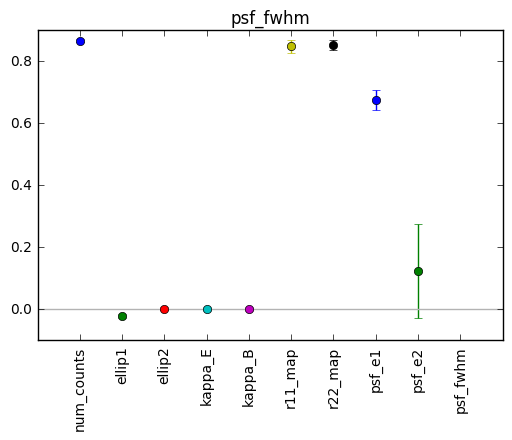

In [102]:
var_list = [num_counts, ellip1, ellip2, kappa_E, kappa_B, r11_map, r22_map, psf_e1, psf_e2, psf_fwhm]
var_names = ['num_counts', 'num_counts', 'ellip1', 'ellip1', 'ellip2', 'ellip2', 'kappa_E', 'kappa_E', 'kappa_B', 'kappa_B', 'r11_map', 'r11_map', 'r22_map', 'r22_map']
var_names = ['num_counts', 'ellip1', 'ellip2', 'kappa_E', 'kappa_B', 'r11_map', 'r22_map', 'psf_e1', 'psf_e2', 'psf_fwhm']
var_lims = [[-.15,.15], [-.05,.05], [-.05,.05], [-.07,.05], [-.05,.05], [-.015,.015], [-.015,.015], [-.05,.05], [-.05,.05], [-.2,.2]]

for i in range(len(var_list)):
    plt.figure(i)
    var_a = var_list[i]
    for j in range(len(var_list)):
        if i!= j:
            var_b = var_list[j]
            Xcorr, Xcorr_err = cross_corr(var_a[mask], var_b[mask], params['jk'], None)
            plt.errorbar(j, Xcorr, Xcorr_err, marker = 'o')
        print "Cross-corr("+var_names[i]+ ","+ var_names[j]+ ") = "+str(Xcorr) + " +/- "+ str(Xcorr_err)
    plt.title(var_names[i])
    plt.xticks(np.arange(len(var_names)), var_names, rotation='vertical')
    #plt.ylim(var_lims[i])
    plt.xlim(-1, len(var_names))
    plt.hlines(0,-1,len(var_names), colors=[.7,.7,.7])
    plt.show()

Observations:
- Strong correlation between number counts and PSF size (and PSF e1). It seems there high quality regions where we detect a) more objects with b) smaller PSFs. This could also be the cause for the correlation with the Metacal responses.
- anticorrelation between e1 and PSF_e1, and correlation between e1 and PSF_e2. It might come from not good enough calibration, or not too precise PSF estimation. e1 is also anticorrelated with the PSF size, so e1 might depend on the data quality. 
- e1 and e2 correlated. This might come from an uncorrected bias. This can depend on the calibration scheme as well. 
- kappa_B anticorrelated with PSF_e2
- Metacal responses are correlated with number counts, PSF_e1 and PSF size. 
- PSF size is correlated with e1 but not with e2. Any possible reason for this?

I am not sure about how significant they are, given the amount of data, area, etc. 

# some examples of the smoothed versions of the maps

Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 4.246609 arcmin (0.001235 rad) 
-> fwhm is 10.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


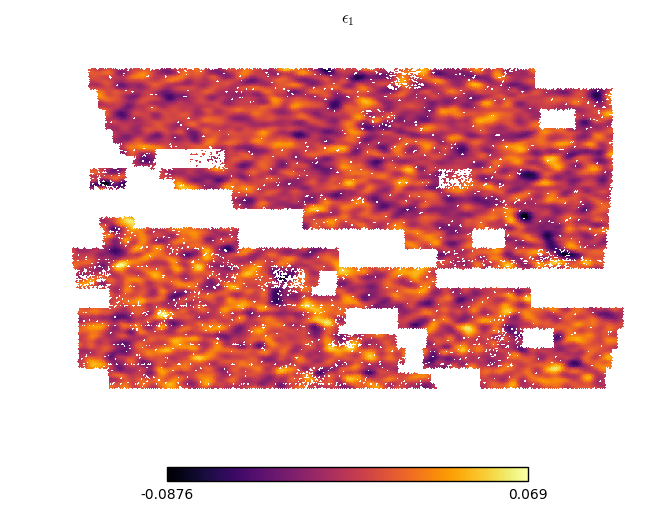

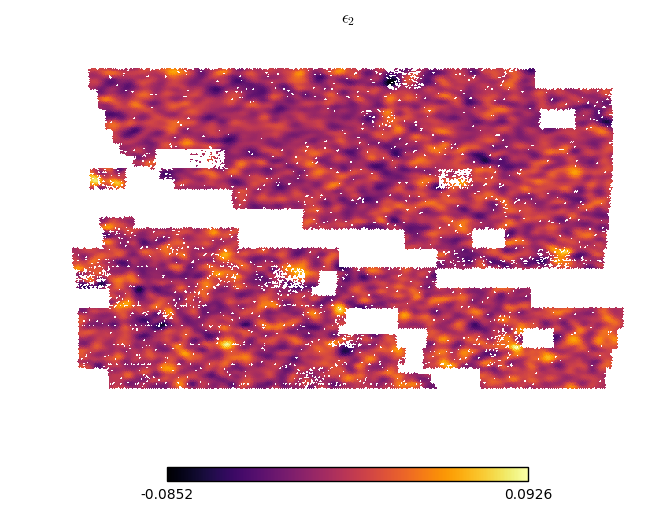

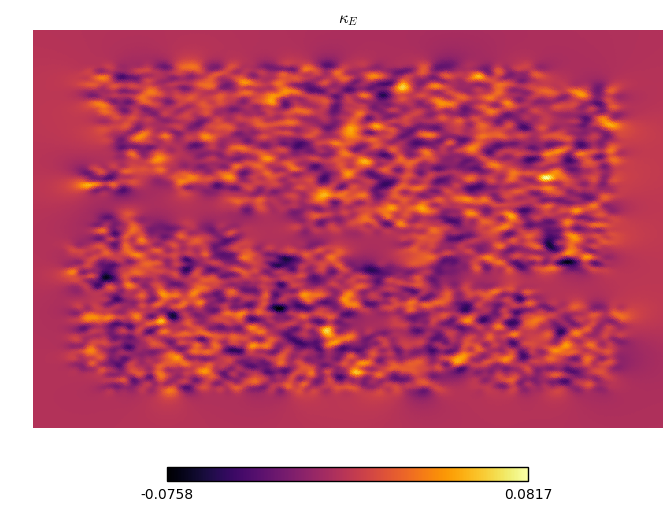

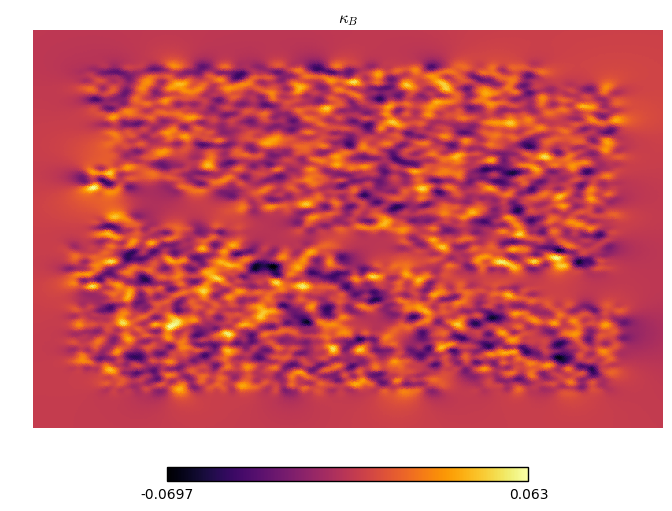

In [101]:
ellip1_sm = hp.smoothing(ellip1, fwhm = params['smooth']/60./180*np.pi)
ellip2_sm = hp.smoothing(ellip2, fwhm = params['smooth']/60./180*np.pi)
kappa_E_sm = hp.smoothing(kappa_E, fwhm = params['smooth']/60./180*np.pi)
kappa_B_sm = hp.smoothing(kappa_B, fwhm = params['smooth']/60./180*np.pi)
hp.cartview(ellip1_sm, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno')#, min = -.1, max = .2)
plt.title(r'$\epsilon_1$')
plt.show()
hp.cartview(ellip2_sm, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno')#, min = -.1, max = .2)
plt.title(r'$\epsilon_2$')
plt.show()
hp.cartview(kappa_E_sm, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno')#, min = -.1, max = .2)
plt.title(r'$\kappa_E$')
plt.show()
hp.cartview(kappa_B_sm, lonra = [np.min(data['ra']) - 360 - 1, np.max(data['ra']) - 360 + 1], latra = [np.min(data['dec']) - 1, np.max(data['dec']) + 1], cmap = 'inferno')#, min = -.1, max = .2)
plt.title(r'$\kappa_B$')
plt.show()